In [ ]:
#import nltk
#nltk.download()

In [1]:
import numpy as np
import pandas as pd
import tweepy
import json
import pymongo
import string
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from collections import Counter

from wordcloud import WordCloud, STOPWORDS  # package used to generate word clouds
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pylab import rcParams

# mostra os graficos no notebook
%matplotlib inline
rcParams['figure.figsize'] = 15, 10  # this is the size of each figure

In [2]:
# Criando a conexão ao MongoDB
cliente1 = pymongo.MongoClient('localhost', 27017)
col = cliente1.twitterdb.tweets
col.count()

8976

In [3]:
def process(text, tokenizer = TweetTokenizer(), stopwords=[]):
    # Processa o texto dos tweeters: lowercase, tokenize, stopword remove, digits remove e retorna lista de strings
    text = text.lower()
    text = re.sub(r'https:.*$', ":", text) # remove a http(URL)
    tokens = tokenizer.tokenize(text)
    #for tok in tokens:
    #    if tok not in stopwords and not tok.isdigit():
    #        return [tok]
    return[tok for tok in tokens if tok not in stopwords and not tok.isdigit()]    

In [4]:
tweet_tokenizer = TweetTokenizer()
punct = list(string.punctuation)
stopword_list = stopwords.words('spanish') + stopwords.words('english')+punct + ['rt','via','...','¿','si','cómo','“','”','¡','q','esas','cosas','https']
tf = Counter()

In [5]:
tweet_cursor = col.find()

for docto in tweet_cursor:
    
    tokens = process(text=docto['text'],
                     tokenizer = tweet_tokenizer,
                     stopwords=stopword_list)
    tf.update(tokens)


In [6]:
word_lista = ' '
for tag, count in tf.most_common(80):
    #print("{}:{}".format(tag,count))
    word_lista = word_lista+','+tag

In [7]:
#word_lista

In [8]:
def show_words_cloud(text):
    twitter_mask = np.array(Image.open("twitter_image.png"))

    wcloud = WordCloud(background_color="white", max_words=200,
                       mask=twitter_mask, max_font_size=60,
                       stopwords=STOPWORDS.add("RT"))

    wcloud.generate(text)

    plt.figure()
    plt.imshow(wcloud)
    plt.axis("off")
    plt.show()

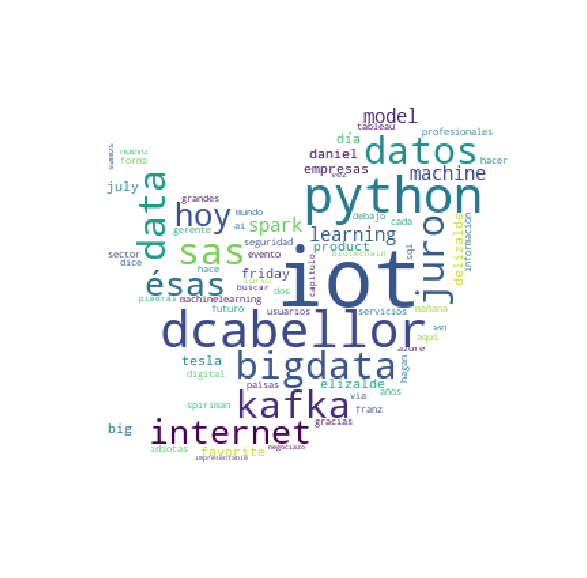

In [9]:
show_words_cloud(word_lista)

In [10]:
dataset = [{"text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
           } for item in col.find()]

dataset = pd.DataFrame(dataset)


In [11]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""

Twitter for iPad        142
Botize                  170
Twitter Lite            186
TweetDeck               193
Statistics for IT       200
Hootsuite               334
IFTTT                   530
Twitter for iPhone     1319
Twitter Web Client     1780
Twitter for Android    2773
Name: source, dtype: int64

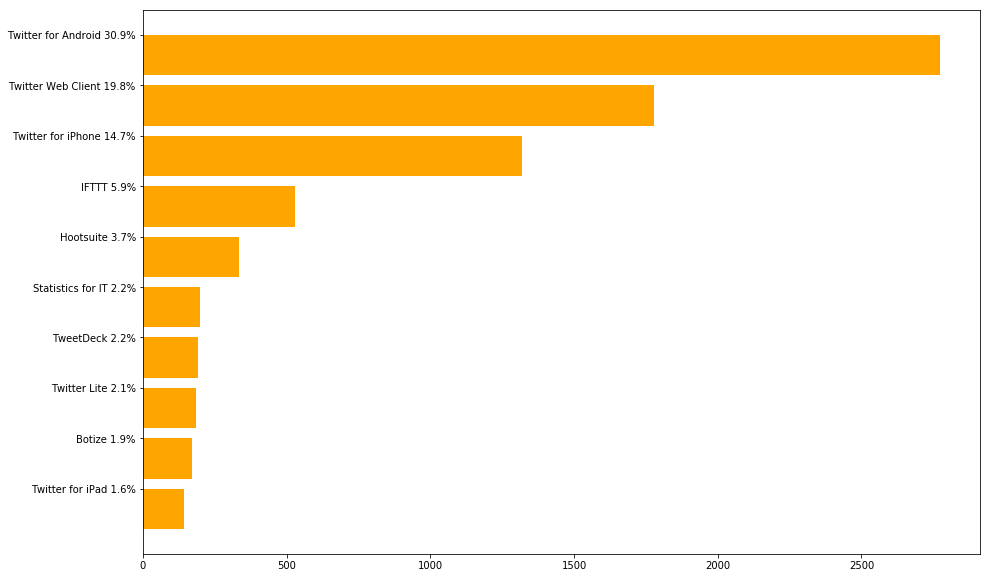

In [12]:
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="orange", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts